[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U3Pb8Bft24vqCrBbkujJNQkTLfInn3GB?usp=sharing)

Sources:
- https://github.com/huggingface/notebooks/blob/main/examples/image_classification-tf.ipynb
- https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb

# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a TensorFlow version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.TFViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.TFSwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.TFConvNextForImageClassification)
* [RegNet](https://huggingface.co/docs/transformers/master/en/model_doc/regnet#transformers.TFRegNetForImageClassification)
* [ResNet](https://huggingface.co/docs/transformers/master/en/model_doc/resnet#transformers.TFResNetForImageClassification)

- in short, any model supported by [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.TFAutoModelForImageClassification).

## Data augmentation

This notebook leverages TensorFlow's [image](https://www.tensorflow.org/api_docs/python/tf/image) module for applying data augmentation. Alternative notebooks which leverage other libraries such as [Albumentations](https://albumentations.ai/) to come!

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

In [ ]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
batch_size = 32

Before we start, let's install the `datasets` and `transformers` libraries.

In [ ]:
!pip install -q -U datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument.

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor.size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'height': 224, 'width': 224}

In [ ]:
from datasets import load_dataset
from PIL import Image
import numpy as np

dataset = load_dataset("cifar100", num_proc=8)

# rename coarse_label and remove fine_label that we are not use for this problem
for split in dataset.keys():
  dataset[split] = dataset[split].remove_columns("fine_label")
  dataset[split] = dataset[split].rename_column("coarse_label", "label")

dataset

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Setting num_proc from 8 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Setting num_proc from 8 back to 1 for the test split to disable multiprocessing as it only contains one shard.


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-5-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
example = dataset["train"][10]
example

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 5}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [ ]:
dataset["train"].features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

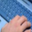

In [ ]:
example['img']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

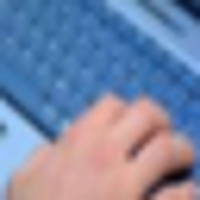

In [ ]:
example['img'].resize((200, 200))

Let's print the corresponding label:

In [ ]:
example['label']

5

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[5]

'household_electrical_devices'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `tf.image` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using `.map()` or `.set_transform()`).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [ ]:
import tensorflow as tf
from keras import layers


# Create data augmentation with keras as we already see in previous notebooks
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(factor=0.2),
  ]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image as keras_image

# normalize image function using Keras backend for epsilon
def normalize_img(img, mean, std):
    mean = tf.constant(mean, dtype=img.dtype)
    std = tf.constant(std, dtype=img.dtype)
    return (img - mean) / tf.maximum(std, K.epsilon())

# function to resize image to a target size
def resize_image(img, target_size):
    return tf.image.resize(img, target_size)

# function to apply data augmentation
def data_augmentation(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img

# transform function for training images
def train_transforms(image):
    image = keras_image.img_to_array(image)
    image = resize_image(image, (224, 224))
    image = data_augmentation(image)
    image /= 255.0  # Scale pixel values to [0, 1]
    image = normalize_img(image,
                          mean=feature_extractor.image_mean,
                          std=feature_extractor.image_std)
    return tf.transpose(image, (2, 0, 1))

# preprocess function for training batch
def preprocess_train(example_batch):
    example_batch['pixel_values'] = [train_transforms(img.convert("RGB")) for img in example_batch["img"]]
    return example_batch

# preprocess function for validation batch (assuming same as train for simplicity)
def preprocess_val(example_batch):
    return preprocess_train(example_batch)


Next, we can preprocess our dataset by applying these functions. We will use the set_transform functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

Let's access an element to see that we've added a "pixel_values" feature:

### Training with Keras

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `TFAutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head.

In [ ]:
from transformers import TFAutoModelForImageClassification, AutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
Total params: 85814036 (327.35 MB)
Trainable params: 85814036 (327.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# check model architecture and dimensions
_model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

_model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [ ]:
learning_rate = 5e-5
weight_decay = 0.01
epochs = 1

Now we initialize our optimizer.

In [ ]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)

Note that most models on the Hub compute loss internally, so we actually don't have to specify anything there! Leaving the loss field blank will cause the model to read the loss head as its loss value.

This is an unusual quirk of TensorFlow models in 🤗 Transformers, so it's worth elaborating on in a little more detail. All 🤗 Transformers models are capable of computing an appropriate loss for their task internally (for example, a CausalLM model will use a cross-entropy loss). To do this, the labels must be provided in the input dict (or equivalently, in the `columns` argument to `to_tf_dataset()`), so that they are visible to the model during the forward pass.

This is quite different from the standard Keras way of handling losses, where labels are passed separately and not visible to the main body of the model, and loss is handled by a function that the user passes to `compile()`, which uses the model outputs and the label to compute a loss value.

The approach we take is that if the user does not pass a loss to `compile()`, the model will assume you want the **internal** loss. If you are doing this, you should make sure that the labels column(s) are included in the **input dict** or in the `columns` argument to `to_tf_dataset`.

If you want to use your own loss, that is of course possible too! If you do this, you should make sure your labels column(s) are passed like normal labels, either as the **second argument** to model.fit(), or in the `label_cols` argument to `to_tf_dataset`.

In [ ]:
model.compile(optimizer=optimizer)

We need to convert our datasets to a format Keras understands. The easiest way to do this is with the `to_tf_dataset()` method. Note that our data collators are designed to work for multiple frameworks, so ensure you set the `return_tensors='np'` argument to get NumPy arrays out - you don't want to accidentally get a load of `torch.Tensor` objects in the middle of your nice TF code! You could also use `return_tensors='tf'` to get TensorFlow tensors, but our `to_tf_dataset` pipeline actually uses a NumPy loader internally, which is wrapped at the end with a `tf.data.Dataset`. As a result, `np` is usually more reliable and performant when you're using it!

In [ ]:
from transformers import DefaultDataCollator

In [ ]:
data_collator = DefaultDataCollator(return_tensors="np")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

`train_set` is now a `tf.data.Dataset` type object. We see that it contains two elements - `labels` and `pixel_values` (but not `image`) as a result of the preprocessing done in `preprocess_train`.

In [ ]:
train_set

<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None)}>

In [ ]:
batch = next(iter(train_set))
batch

{'labels': <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([17, 18, 19, 19,  9,  2, 16,  1,  0, 10, 13, 17,  5, 10,  0,  0,  5,
         6, 10,  6,  1,  1,  9,  8,  0,  2,  4,  4, 14, 19, 14, 17])>,
 'pixel_values': <tf.Tensor: shape=(32, 3, 224, 224), dtype=float32, numpy=
 array([[[[-0.68814933, -0.68814933, -0.68814933, ...,  0.98855484,
            0.98855484,  0.98855484],
          [-0.68814933, -0.68814933, -0.68814933, ...,  0.98855484,
            0.98855484,  0.98855484],
          [-0.68814933, -0.68814933, -0.68814933, ...,  0.98855484,
            0.98855484,  0.98855484],
          ...,
          [-0.656662  , -0.656662  , -0.656662  , ..., -0.5228405 ,
           -0.5228405 , -0.5228405 ],
          [-0.656662  , -0.656662  , -0.656662  , ..., -0.5228405 ,
           -0.5228405 , -0.5228405 ],
          [-0.656662  , -0.656662  , -0.656662  , ..., -0.5228405 ,
           -0.5228405 , -0.5228405 ]],
 
         [[-0.49220514, -0.49220514, -0.49220514, ...,  0.97983086,

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits.

In addition, let's wrap this metric computation function in a `KerasMetricCallback`. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like TensorBoard and EarlyStopping.

Why do it this way, though, and not just use a straightforward Keras Metric object? This is a good question - on this task, metrics such as Accuracy are very straightforward, and it would probably make more sense to just use a Keras metric for those instead. However, we want to demonstrate the use of `KerasMetricCallback` here, because it can handle any arbitrary Python function for the metric computation.

Wow do we actually use `KerasMetricCallback`? We simply define a function that computes metrics given a tuple of numpy arrays of predictions and labels, then we pass that, along with the validation set to compute metrics on, to the callback:

In [ ]:
import numpy as np
from transformers.keras_callbacks import KerasMetricCallback

# the compute_metrics function takes a Tuple as input:
# first element is the logits of the model as Numpy arrays,
# second element is the ground-truth labels as Numpy arrays.
def compute_metrics(eval_predictions):
    predictions = np.argmax(eval_predictions[0], axis=1)
    metric_val = metric.compute(predictions=predictions, references=eval_predictions[1])
    return {"val_" + k: v for k, v in metric_val.items()}

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=val_set, batch_size=batch_size, label_cols=['labels']
)

Now we can train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [ ]:
callbacks = [metric_callback]

In [ ]:
 model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
    batch_size=batch_size,
)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1407/1407 [==============================] - 2270s 2s/step - loss: 0.6775 - val_loss: 0.2382 - val_accuracy: 0.9406


## Inference

Let's say you have a new image, on which you'd like to make a prediction.

Label: aquatic_mammals


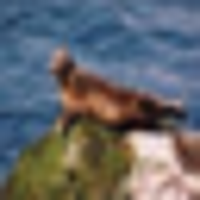

In [ ]:
image = dataset['test'][2]['img']
label_id = dataset['test'][2]['label']
print(f'Label: {model.config.id2label[label_id]}')
image.resize((200, 200))

In [ ]:
# prepare image for the model
image_preprocessed = train_transforms(image)
model_input = {'pixel_values': tf.expand_dims(image_preprocessed, axis=0)}

In [ ]:
outputs = model(model_input)
logits = outputs.logits

In [ ]:
predicted_class_idx = tf.math.argmax(logits, -1).numpy()[0]
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: aquatic_mammals
